In [ ]:
!pip install emoji
!pip install langchain-huggingface
!pip install torch
!pip install tensorflow==2.9.1

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime
import random
import emoji
import matplotlib.pyplot as plt
from google.colab import drive
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import initializers, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, LayerNormalization, MaxPooling1D, SpatialDropout1D, LSTM, GRU, Attention
from keras.models import Model
from keras.regularizers import l1, l2
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.optim import AdamW

import transformers
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, get_linear_schedule_with_warmup


In [ ]:
def downloadAll():
  nltk.download('stopwords')
  nltk.download('punkt')
  nltk.download('wordnet')

In [ ]:
def getFilesFromDrive():
  drive.mount('/content/drive')
  !unzip /content/drive/MyDrive/Kaggle/cyber-bullying.zip
  !unzip /content/drive/MyDrive/Kaggle/google-news.zip

In [ ]:
downloadAll()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
getFilesFromDrive()

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Kaggle/cyber-bullying.zip
  inflating: cyberbullying_tweets.csv  
Archive:  /content/drive/MyDrive/Kaggle/google-news.zip
  inflating: GoogleNews-vectors-negative300.bin  
  inflating: GoogleNews-vectors-negative300.bin.gz  


In [ ]:
df = pd.read_csv("cyberbullying_tweets.csv")
#remove duplicated tweets
df = df[~df.duplicated()]

In [ ]:
len(df)

47656

In [ ]:
def count_df(df, column, typeColumn):
  count = 0
  for i in range(len(df)):
    if df[column].iloc[i] == typeColumn:
      count += 1
  return count


count_not = count_df(df, 'cyberbullying_type', 'not_cyberbullying')
count_gen = count_df(df, 'cyberbullying_type', 'gender')
count_rel = count_df(df, 'cyberbullying_type', 'religion')
count_oth = count_df(df, 'cyberbullying_type', 'other_cyberbullying')
count_age = count_df(df, 'cyberbullying_type', 'age')
count_eth = count_df(df, 'cyberbullying_type', 'ethnicity')
print("number not: {}\nnumber gender: {}\nnumber religion: {}\nnumber other: {}\nnumber age: {}\nnumber ethnicity: {}".format(count_not, count_gen, count_rel, count_oth, count_age, count_eth))

number not: 7937
number gender: 7948
number religion: 7997
number other: 7823
number age: 7992
number ethnicity: 7959


### **For the paper**

In [ ]:
palette_color = sns.color_palette('bright')

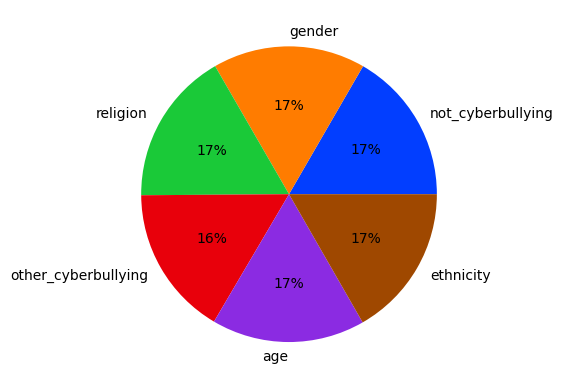

In [ ]:
values_pie = [count_not, count_gen, count_rel, count_oth, count_age, count_eth]
keys_pie = ["not_cyberbullying", "gender", "religion", "other_cyberbullying", "age", "ethnicity"]

plt.pie(values_pie, labels=keys_pie, colors=palette_color, autopct='%.0f%%')
plt.show()

SVM - 54
NB - 52
LSTM - 45
CNN - 40
LR - 39
RF - 31
BERT - 23
DT - 21
GRU - 17
KNN - 17
XGBoost - 12
MNB - 12
AdaBoost - 7
LightGBM - 3

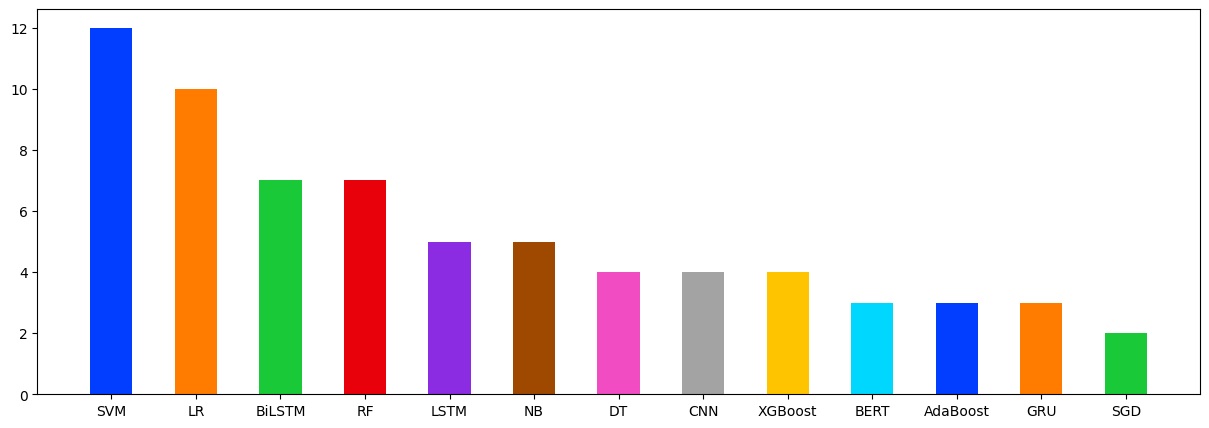

In [ ]:
x = ["SVM", "LR", "BiLSTM", "RF", "LSTM", "NB", "DT", "CNN", "XGBoost", "BERT", "AdaBoost", "GRU", "SGD"]
y = [12, 10, 7, 7, 5, 5, 4, 4, 4, 3, 3, 3, 2]

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

plt.bar(x, y, width=0.5, color=palette_color)
plt.show()

In [ ]:
random_df = df.copy()
#Shuffle Data Frame
random_df = random_df.sample(frac = 1)

In [ ]:
random_df.head(15)

,tweet_text,cyberbullying_type
38939,Your right I was that girl that bullied you in...,age
43648,@Magikk90h9 No not yet but they did search me ...,ethnicity
23920,@1Life0Continues i've got the code to interpre...,other_cyberbullying
4397,thanks goodness the internet allows people to ...,not_cyberbullying
31922,bitches will bully you in middle school and th...,age
12729,WATCH: Audience Revolts After Margaret Cho Jok...,gender
8081,Retweeted Avi (@AviAhvee): Just gonna keep a r...,gender
40499,Racism is wen u select ur white cloth to wash ...,ethnicity
14598,You are aware Cornette has a well documented h...,gender
44166,Im leader of Sir Dumb Fuck face U stupid Nigge...,ethnicity


### <b>Preprocessing</b>

In [ ]:
def removeCitation(text):
  pattern = r'@\S+'
  result = re.sub(pattern, " ", text)
  return result

def removeComments(text):
  pattern = r'#\S+'
  result = re.sub(pattern, " ", text)
  return result

def removeURL(text):
  pattern = r'http\S+'
  result = re.sub(pattern, " ", text)
  return result

def removePunckation(text):
  pattern = r'[^\w\s]'
  result = re.sub(pattern, " ", text)
  return result

def removeNumber(text):
  pattern = r'\d'
  result = re.sub(pattern, " ", text)
  return result

def removeUnderScore(text):
  pattern = r'_'
  result = re.sub(pattern, " ", text)
  return result

# Clean emojis from text
def strip_emoji(text):
  return emoji.replace_emoji(text, replace=" ")

def returnNan(text):
  if(text == " "):
    return np.nan
  return text

In [ ]:
def cleaningText(text):
  new_data = removeCitation(text)
  new_data = removeComments(new_data)
  new_data = removeURL(new_data)
  new_data = removePunckation(new_data)
  new_data = removeNumber(new_data)
  new_data = removeUnderScore(new_data)
  new_data = strip_emoji(new_data)
  new_data = new_data.lower()
  new_data = returnNan(new_data)
  return new_data

In [ ]:
pP_df = random_df.copy()
pP_df['tweet_text'] = pP_df['tweet_text'].apply(cleaningText)
pP_df.head(5)

,tweet_text,cyberbullying_type
15346,i m watching netflix s comedians of the world...,gender
14103,rt tattoos are disgusting on women not sexi...,gender
36191,the one girl in ur high school friend group th...,age
35941,elementary and middle school pe what primarily...,age
19299,allah the terrorist can stick what he wants ...,religion


In [ ]:
print(len(pP_df))
pP_df = pP_df.dropna()
print(len(pP_df))

47656
47527


In [ ]:
lem = WordNetLemmatizer()
def preProcessing(text):
  #tokenize words
  word_tokenized = word_tokenize(text)

  #remove stop words
  stop_words_en = set(stopwords.words('english'))
  without_stop_words = []
  for word in word_tokenized:
    if word not in stop_words_en:
      without_stop_words.append(word)

  #lemmatizing the words
  new_lemmatize_words = []
  for word in without_stop_words:
    new_lemmatize_words.append(lem.lemmatize(word))

  return new_lemmatize_words

In [ ]:
pP_df['tweet_text'] = pP_df['tweet_text'].apply(preProcessing)
pP_df.head(5)

,tweet_text,cyberbullying_type
15346,"[watching, netflix, comedian, world, represent...",gender
14103,"[rt, tattoo, disgusting, woman, sexist, true]",gender
36191,"[one, girl, ur, high, school, friend, group, a...",age
35941,"[elementary, middle, school, pe, primarily, le...",age
19299,"[allah, terrorist, stick, want, giant, as]",religion


In [ ]:
new_data = {
    "tokens": pP_df['tweet_text'],
    "cyberbullying_type": pP_df['cyberbullying_type']
}
new_df = pd.DataFrame(new_data)
new_df.head(10)

,tokens,cyberbullying_type
15346,"[watching, netflix, comedian, world, represent...",gender
14103,"[rt, tattoo, disgusting, woman, sexist, true]",gender
36191,"[one, girl, ur, high, school, friend, group, a...",age
35941,"[elementary, middle, school, pe, primarily, le...",age
19299,"[allah, terrorist, stick, want, giant, as]",religion
41571,"[nigger, bitch, tht, demanded, get, cigs, fuck...",ethnicity
33973,"[get, dumb, also, sister, tall, girl, deal, w,...",age
16388,"[serious, education, problem, country, cutting...",religion
11364,"[rt, man, buy, pink, store, man, cave, mislead...",gender
46965,"[someone, called, mom, dumb, as, nigger, block...",ethnicity


In [ ]:
count_not = count_df(new_df, 'cyberbullying_type', 'not_cyberbullying')
count_gen = count_df(new_df, 'cyberbullying_type', 'gender')
count_rel = count_df(new_df, 'cyberbullying_type', 'religion')
count_oth = count_df(new_df, 'cyberbullying_type', 'other_cyberbullying')
count_age = count_df(new_df, 'cyberbullying_type', 'age')
count_eth = count_df(new_df, 'cyberbullying_type', 'ethnicity')
print("number not: {}\nnumber gender: {}\nnumber religion: {}\nnumber other: {}\nnumber age: {}\nnumber ethnicity: {}".format(count_not, count_gen, count_rel, count_oth, count_age, count_eth))

number not: 7902
number gender: 7933
number religion: 7997
number other: 7747
number age: 7992
number ethnicity: 7956


**Before removing empty lines**

number not: 7937

number gender: 7948

number religion: 7997

number other: 7823

number age: 7992

number ethnicity: 7959

**After removing empty lines**

number not: 7902

number gender: 7933

number religion: 7997

number other: 7747

number age: 7992

number ethnicity: 7956

### **Spliting the data**

In [ ]:
def splitData(X, Y, test_size):
  return train_test_split(X, Y, test_size=test_size, stratify=Y)

In [ ]:
X_train, X_test, Y_train, Y_test = splitData(new_df['tokens'], new_df['cyberbullying_type'], 0.2)
print(len(X_train), len(X_test))

38021 9506


In [ ]:
# X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5) validation

In [ ]:
y_tr = Y_train
y_test = Y_test

In [ ]:
le = LabelEncoder()
le.fit(y_tr)

LabelEncoder()

In [ ]:
labels_name = le.classes_
print(labels_name)

['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']


In [ ]:
y_tr = le.transform(y_tr)
print(y_tr)

[3 2 2 ... 3 0 1]


In [ ]:
len(y_tr)

38021

In [ ]:
# y_val = le.transform(Y_val)
# print(y_val) - validation

### <b>Training vocabullary</b>

In [ ]:
all_training_words = [word for tokens in list(X_train) for word in tokens]
training_sentence_length = [len(tokens) for tokens in list(X_train)]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("{} words total, with a vocabulary size of {}".format(len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_length))
print(max(all_training_words))

480720 words total, with a vocabulary size of 30980
Max sentence length is 325
𝚎𝚕𝚞𝚜𝚒𝚟𝚎


### <b>Testing vocabullary</b>

In [ ]:
all_testing_words = [word for tokens in list(X_test) for word in tokens]
testing_sentence_lenght = [len(tokens) for tokens in list(X_test)]
TESTING_VOCAB = sorted(list(set(all_testing_words)))
print("{} words total, with a vocabulary size of {}".format(len(all_testing_words), len(TESTING_VOCAB)))
print("Max sentence length is %s" % max(testing_sentence_lenght))
print(max(all_testing_words))

120795 words total, with a vocabulary size of 14901
Max sentence length is 379
𝔂𝓸𝓾


--------------------------------------------------

### <b>Loading Google News Word2Vec Model</b>

In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [ ]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def word2Vec_training():
  global TRAINING_VOCAB, X_train, word2vec, MAX_SEQUENCE_LENGTH, X_test, X_val

  tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
  tokenizer.fit_on_texts(list(X_train))
  training_sequences = tokenizer.texts_to_sequences(list(X_train))

  train_word_index = tokenizer.word_index
  print("Found {} unique tokens.".format(len(train_word_index)))

  train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  train_embedding_weight = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

  for word, index in train_word_index.items():
    train_embedding_weight[index, :] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
  print(train_embedding_weight.shape)

  test_sequences = tokenizer.texts_to_sequences(list(X_test))
  test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

  return train_embedding_weight, train_data, test_data, train_word_index

In [ ]:
train_embedding_weight, train_cnn_data, test_cnn_data, train_word_index = word2Vec_training()

Found 30980 unique tokens.
(30981, 300)


In [ ]:
x_train = train_cnn_data
x_test = test_cnn_data

In [ ]:
def createPredictionsLabels(predictions, labels):
  predictions_labels = []
  for p in predictions:
    predictions_labels.append(labels[np.argmax(p)])
  return predictions_labels

### **BERT**

In [ ]:
# Loading DistilBERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
X_train_bert, X_test_bert, Y_train_bert, Y_test_bert = splitData(new_df['tokens'], new_df['cyberbullying_type'], 0.2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
texts_train = [' '.join(words) for words in X_train_bert]
print(texts_train[:10])


['person elementary school bully mentality laughing stock world right', 'imagine identical incident belonged trump joy reid maddow would pin label infamous blue board slam racism despise two faced people hard know face slap pick stance stay pander rating', 'getting close bitching grade bus making many gay rape joke', 'eep yeah shoe would pretty dangerous', 'want anymore white as crazy drama show hulu called taken birth white doctor sold baby back door clinic door small town negro sight good old hot aryan mess', 'dormir cedo porque amanhã dia vai ser cheio demais pode ser considerado bullying', 'high school regularly called f g hallway could act like anybody real bullied dressing like e boy girl cool smh', 'say rape unnecessary time joke use word gay insult expect respect', 'agreed sure w', 'coz one else']


In [ ]:
texts_test = [' '.join(words) for words in X_test_bert]
print(texts_test[:10])

['meagan good thats good fine christian woman right', 'kashi ka meer reference lord shiva idiot try change history remains know may muslim kashmir year', 'ur first one', 'clear difference halal water halal meat dont cut throat water let die pain idiot also white guy comment extremely racist sikh race like muslim x', 'garrison rad committed upkeep', 'ummah mean nation idiot zakat go muslim lol cant even give non muslim show wicked islam zakat tax islamic ummah nation hajj money used fund terror many yemeni killed', 'stepdad walked room offer pot wa farted second declined', '', 'wonder kat ask everyone bum durrie', 'everyone joking inhale friend using gay slur camera agrees friend said kid cancelled since laughed rape joke']


In [ ]:
max_len = 0

# For every sentence...
for sent in texts_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  397


In [ ]:
input_ids = []
attention_masks = []

for text in texts_train:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation=True, # explicitly truncate examples to max length
                        padding = 'max_length',  # to pad to a max length
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
c_input_ids = input_ids.copy()
c_attention_masks = attention_masks.copy()

In [ ]:
leT = LabelEncoder()
labels_train = list(leT.fit_transform(Y_train_bert))
labels_train[:15]

[0, 1, 2, 4, 1, 3, 0, 2, 3, 4, 5, 0, 3, 4, 4]

In [ ]:
labels_test = list(leT.fit_transform(Y_test_bert))
print(labels_test[:15])

[5, 5, 1, 5, 4, 5, 4, 3, 2, 2, 0, 4, 5, 1, 5]


In [ ]:
# Convert the lists into tensors.
c_input_ids = torch.cat(c_input_ids, dim=0)
c_attention_masks = torch.cat(c_attention_masks, dim=0)
labels = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts_train[0])
print('Token IDs:', input_ids[0])
print(labels[:10])

Original:  person elementary school bully mentality laughing stock world right
Token IDs: tensor([[  101,  2711,  4732,  2082, 20716,  5177,  3012,  5870,  4518,  2088,
          2157,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     

In [ ]:
print(max(labels), min(labels))

tensor(5) tensor(0)


In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(c_input_ids, c_attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

34,218 training samples
3,803 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

if device == "cuda:0":
  # Tell pytorch to run this model on the GPU.
  model = model.cuda()

model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

#### **Fine tuning the model**

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import time

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

In [ ]:
# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for data in list(enumerate(train_dataloader)):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        step = data[0]
        batch = data[1]
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        print(loss)
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
tensor(1.9399, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6334, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6252, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6814, device='cuda:0', grad_fn=<NllLossBackward0

#### **Evaluating model**

In [ ]:
model = torch.load('bert_model')

<ipython-input-38-ac35b85e1100>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('bert_model')


In [ ]:
test_input_ids = []
test_attention_masks = []
for text in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

In [ ]:
predictions_names = [labels_name[i] for i in predictions]
print(predictions_names[:10])

['religion', 'religion', 'ethnicity', 'religion', 'not_cyberbullying', 'religion', 'not_cyberbullying', 'other_cyberbullying', 'gender', 'gender']


### **Metrics BERT**

In [ ]:
cm_bert = confusion_matrix(Y_test_bert, predictions_names, labels=labels_name)
print(cm_bert)

[[1560    1    5   18   15    0]
 [   2 1560    2   11   11    5]
 [   0    2 1351  112  120    2]
 [  12    5   68  867  577   51]
 [   5    4   76  391 1070    3]
 [   0    3    9   54   10 1524]]


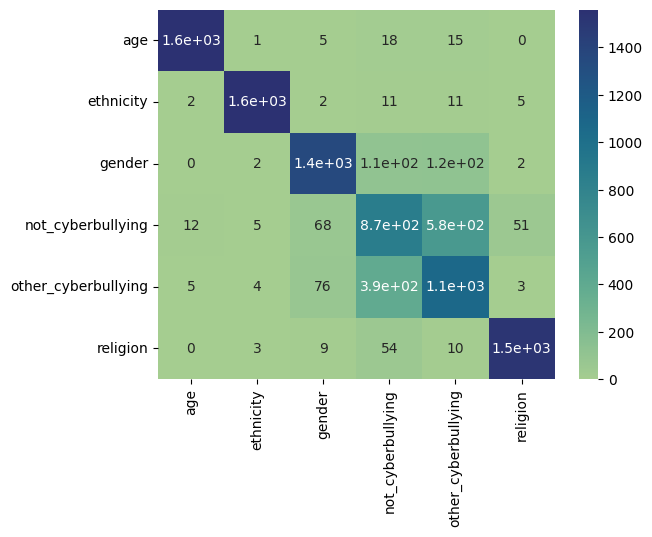

In [ ]:
df_bert = pd.DataFrame(cm_bert, columns=labels_name, index=labels_name)
heatmap_bert = sns.heatmap(df_bert, annot=True, cmap="crest")

In [ ]:
print(classification_report(y_true=Y_test_bert, y_pred=predictions_names, labels=labels_name, target_names=labels_name))

                     precision    recall  f1-score   support

                age       0.99      0.98      0.98      1599
          ethnicity       0.99      0.98      0.99      1591
             gender       0.89      0.85      0.87      1587
  not_cyberbullying       0.60      0.55      0.57      1580
other_cyberbullying       0.59      0.69      0.64      1549
           religion       0.96      0.95      0.96      1600

           accuracy                           0.83      9506
          macro avg       0.84      0.83      0.83      9506
       weighted avg       0.84      0.83      0.84      9506



### **LSTM and GRU**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
def recurrentNet(isLSTM, embedding_weights, index, embedding_dim, hasAttetion):
  embedded_layer = Embedding(index,
                             embedding_dim,
                             weights=[embedding_weights],
                             input_length=MAX_SEQUENCE_LENGTH,
                             trainable=False)

  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
  embedded_sequences = embedded_layer(sequence_input)

  x = SpatialDropout1D(0.5)(embedded_sequences)
  if(hasAttetion == True):
    x = Attention()([x, x])
  if(isLSTM == True):
    x = LSTM(256, return_sequences=True)(x)
  else:
    x = GRU(256, return_sequences=True)(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  preds = Dense(len(labels_name), activation='softmax')(x)

  model = Model(sequence_input, preds)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.summary()
  return model

### **LSTM with Attetion**

In [ ]:
lstm_model = recurrentNet(True, train_embedding_weight, len(train_word_index)+1, EMBEDDING_DIM, True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      9294300     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 50, 300)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 attention (Attention)          (None, 50, 300)      0           ['spatial_dropout1d[0][0]',  

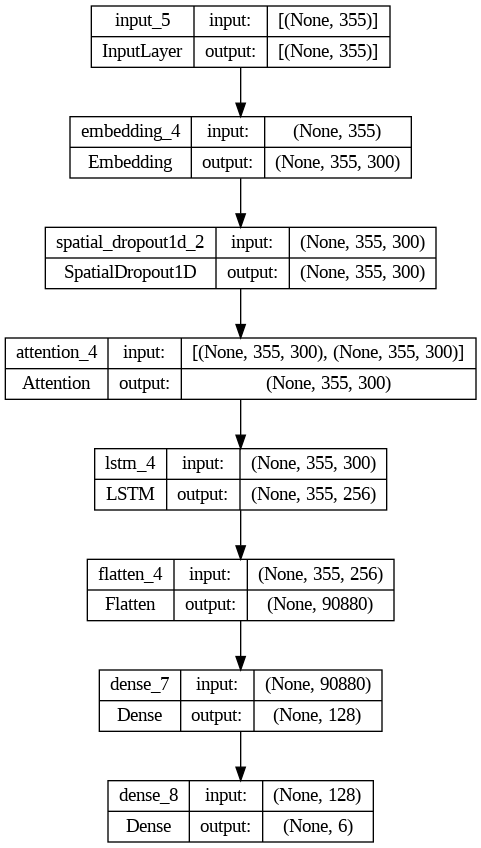

In [ ]:
plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = lstm_model.fit(x_train, y_tr, validation_split=0.2, epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
238/238 [==============================] - 35s 138ms/step - loss: 0.6563 - accuracy: 0.7283 - val_loss: 0.4848 - val_accuracy: 0.7946
Epoch 2/10
238/238 [==============================] - 32s 136ms/step - loss: 0.5082 - accuracy: 0.7863 - val_loss: 0.4513 - val_accuracy: 0.8109
Epoch 3/10
238/238 [==============================] - 33s 137ms/step - loss: 0.4590 - accuracy: 0.8039 - val_loss: 0.4368 - val_accuracy: 0.8172
Epoch 4/10
238/238 [==============================] - 32s 136ms/step - loss: 0.4274 - accuracy: 0.8147 - val_loss: 0.4337 - val_accuracy: 0.8213
Epoch 5/10
238/238 [==============================] - 32s 135ms/step - loss: 0.4009 - accuracy: 0.8295 - val_loss: 0.4261 - val_accuracy: 0.8231
Epoch 6/10
238/238 [==============================] - 32s 136ms/step - loss: 0.3866 - accuracy: 0.8308 - val_loss: 0.4191 - val_accuracy: 0.8256
Epoch 7/10
238/238 [==============================] - 32s 135ms/step - loss: 0.3663 - accuracy: 0.8396 - val_loss: 0.4202 - val_ac

In [ ]:
predictions_lstm = lstm_model.predict(x_test)

298/298 [==============================] - 7s 23ms/step


In [ ]:
pred_lstm_labels = createPredictionsLabels(predictions_lstm, labels_name)
print(pred_lstm_labels[:10])
print(y_test[:10])

['ethnicity', 'other_cyberbullying', 'religion', 'ethnicity', 'religion', 'other_cyberbullying', 'not_cyberbullying', 'ethnicity', 'other_cyberbullying', 'religion']
43066              ethnicity
25913    other_cyberbullying
19018               religion
45921              ethnicity
16584               religion
26073    other_cyberbullying
10709                 gender
45313              ethnicity
24437    other_cyberbullying
17246               religion
Name: cyberbullying_type, dtype: object


### **Metrics LSTM with Attetion**

In [ ]:
cm_lstm = confusion_matrix(y_test, pred_lstm_labels, labels=labels_name)
print(cm_lstm)

[[1558    1   10   15   14    1]
 [   1 1538    9   17   15   11]
 [   0    4 1353   73  153    4]
 [  11    5  118  728  654   64]
 [   9    5  114  314 1105    2]
 [   2    4   15   49   28 1502]]


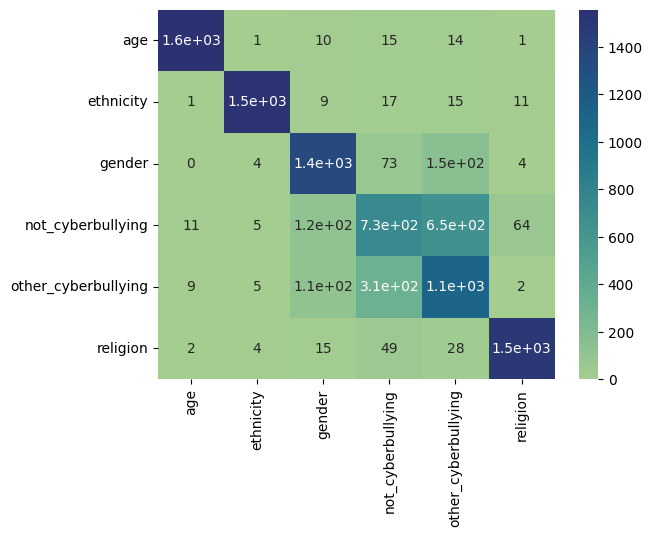

In [ ]:
df_lstm = pd.DataFrame(cm_lstm, columns=labels_name, index=labels_name)
heatmap = sns.heatmap(df_lstm, annot=True, cmap="crest")

In [ ]:
print(classification_report(y_true=y_test, y_pred=pred_lstm_labels, labels=labels_name, target_names=labels_name))

                     precision    recall  f1-score   support

                age       0.99      0.97      0.98      1599
          ethnicity       0.99      0.97      0.98      1591
             gender       0.84      0.85      0.84      1587
  not_cyberbullying       0.61      0.46      0.52      1580
other_cyberbullying       0.56      0.71      0.63      1549
           religion       0.95      0.94      0.94      1600

           accuracy                           0.82      9506
          macro avg       0.82      0.82      0.82      9506
       weighted avg       0.82      0.82      0.82      9506



### <b> GRU with Attetion </b>

In [ ]:
gru_model = recurrentNet(False, train_embedding_weight, len(train_word_index)+1, EMBEDDING_DIM, True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 300)      9294300     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 50, 300)     0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 attention_1 (Attention)        (None, 50, 300)      0           ['spatial_dropout1d_1[0][0]

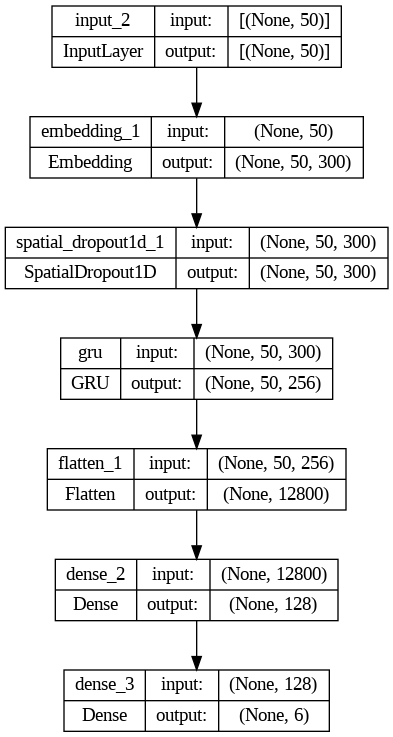

In [ ]:
plot_model(gru_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history_gru = gru_model.fit(x_train, y_tr, validation_split=0.2, epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
238/238 [==============================] - 29s 116ms/step - loss: 0.6352 - accuracy: 0.7378 - val_loss: 0.4791 - val_accuracy: 0.8014
Epoch 2/10
238/238 [==============================] - 27s 112ms/step - loss: 0.4799 - accuracy: 0.7947 - val_loss: 0.4456 - val_accuracy: 0.8137
Epoch 3/10
238/238 [==============================] - 27s 113ms/step - loss: 0.4381 - accuracy: 0.8129 - val_loss: 0.4378 - val_accuracy: 0.8195
Epoch 4/10
238/238 [==============================] - 27s 112ms/step - loss: 0.4142 - accuracy: 0.8216 - val_loss: 0.4342 - val_accuracy: 0.8230
Epoch 5/10
238/238 [==============================] - 27s 112ms/step - loss: 0.3867 - accuracy: 0.8327 - val_loss: 0.4239 - val_accuracy: 0.8256
Epoch 6/10
238/238 [==============================] - 27s 113ms/step - loss: 0.3723 - accuracy: 0.8351 - val_loss: 0.4373 - val_accuracy: 0.8224
Epoch 7/10
238/238 [==============================] - 27s 113ms/step - loss: 0.3555 - accuracy: 0.8431 - val_loss: 0.4236 - val_ac

In [ ]:
predictions = gru_model.predict(x_test)

298/298 [==============================] - 6s 20ms/step


In [ ]:
pred_gru_labels = createPredictionsLabels(predictions, labels_name)

### <b>Metrics GRU</b>

In [ ]:
cm_gru = confusion_matrix(y_test, pred_gru_labels, labels=labels_name)
print(cm_gru)

[[1570    1    6   11   11    0]
 [   1 1550    9   10   13    8]
 [   0    8 1337   92  143    7]
 [  17   11   97  807  591   57]
 [  22    9  109  360 1044    5]
 [   1    7    9   49   25 1509]]


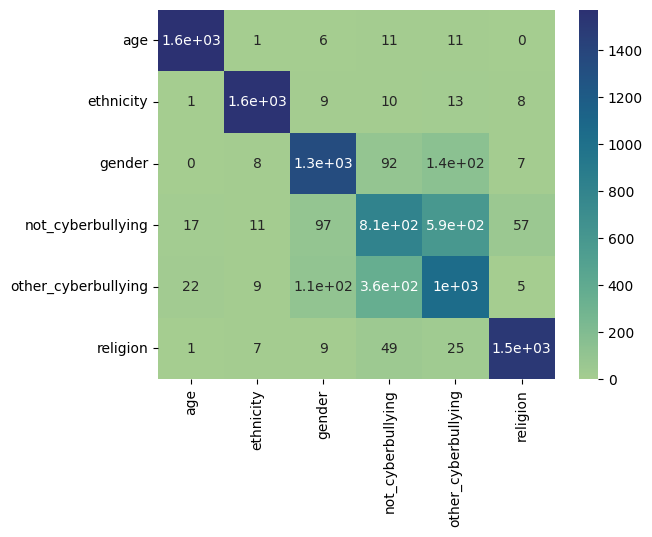

In [ ]:
df_gru = pd.DataFrame(cm_gru, columns=labels_name, index=labels_name)
heatmap = sns.heatmap(df_gru, annot=True, cmap="crest")

In [ ]:
print(classification_report(y_true=y_test, y_pred=pred_lstm_labels, labels=labels_name, target_names=labels_name))

                     precision    recall  f1-score   support

                age       0.99      0.97      0.98      1599
          ethnicity       0.99      0.97      0.98      1591
             gender       0.84      0.85      0.84      1587
  not_cyberbullying       0.61      0.46      0.52      1580
other_cyberbullying       0.56      0.71      0.63      1549
           religion       0.95      0.94      0.94      1600

           accuracy                           0.82      9506
          macro avg       0.82      0.82      0.82      9506
       weighted avg       0.82      0.82      0.82      9506



### <b>CNN</b>

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    #try spatial dropout here
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    # this part is convultional(Conv1D) and pooling layers(GlobalMaxPooling1D)
    for filter_size in filter_sizes:
      l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
      spdt = SpatialDropout1D(0.2)(l_conv)
      l_pool = GlobalMaxPooling1D()(spdt)
      convs.append(l_pool)

    initializer = initializers.RandomUniform(minval=0.0, maxval=1.0)


    l_merge = concatenate(convs, axis=1)
    # this part is full connected layer with Dropout as regularization layer and Dense
    x = Dense(128, activation='relu')(l_merge)
    '''
    First attempt
    x = Dense(128, activation='relu')(l_merge)
    x = LayerNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = LayerNormalization()(x)
    '''
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc']) # categorical_crossentropy sparse_categorical_crossentropy

    model.summary()
    return model

In [ ]:
model = ConvNet(train_embedding_weight,
                MAX_SEQUENCE_LENGTH,
                len(train_word_index)+1,
                EMBEDDING_DIM,
                len(labels_name))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 300)              1159050   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_25 (Conv1D)          (None, 49, 200)              120200    ['embedding_6[0][0]']         
                                                                                                  
 conv1d_26 (Conv1D)          (None, 48, 200)              180200    ['embedding_6[0][0]']   

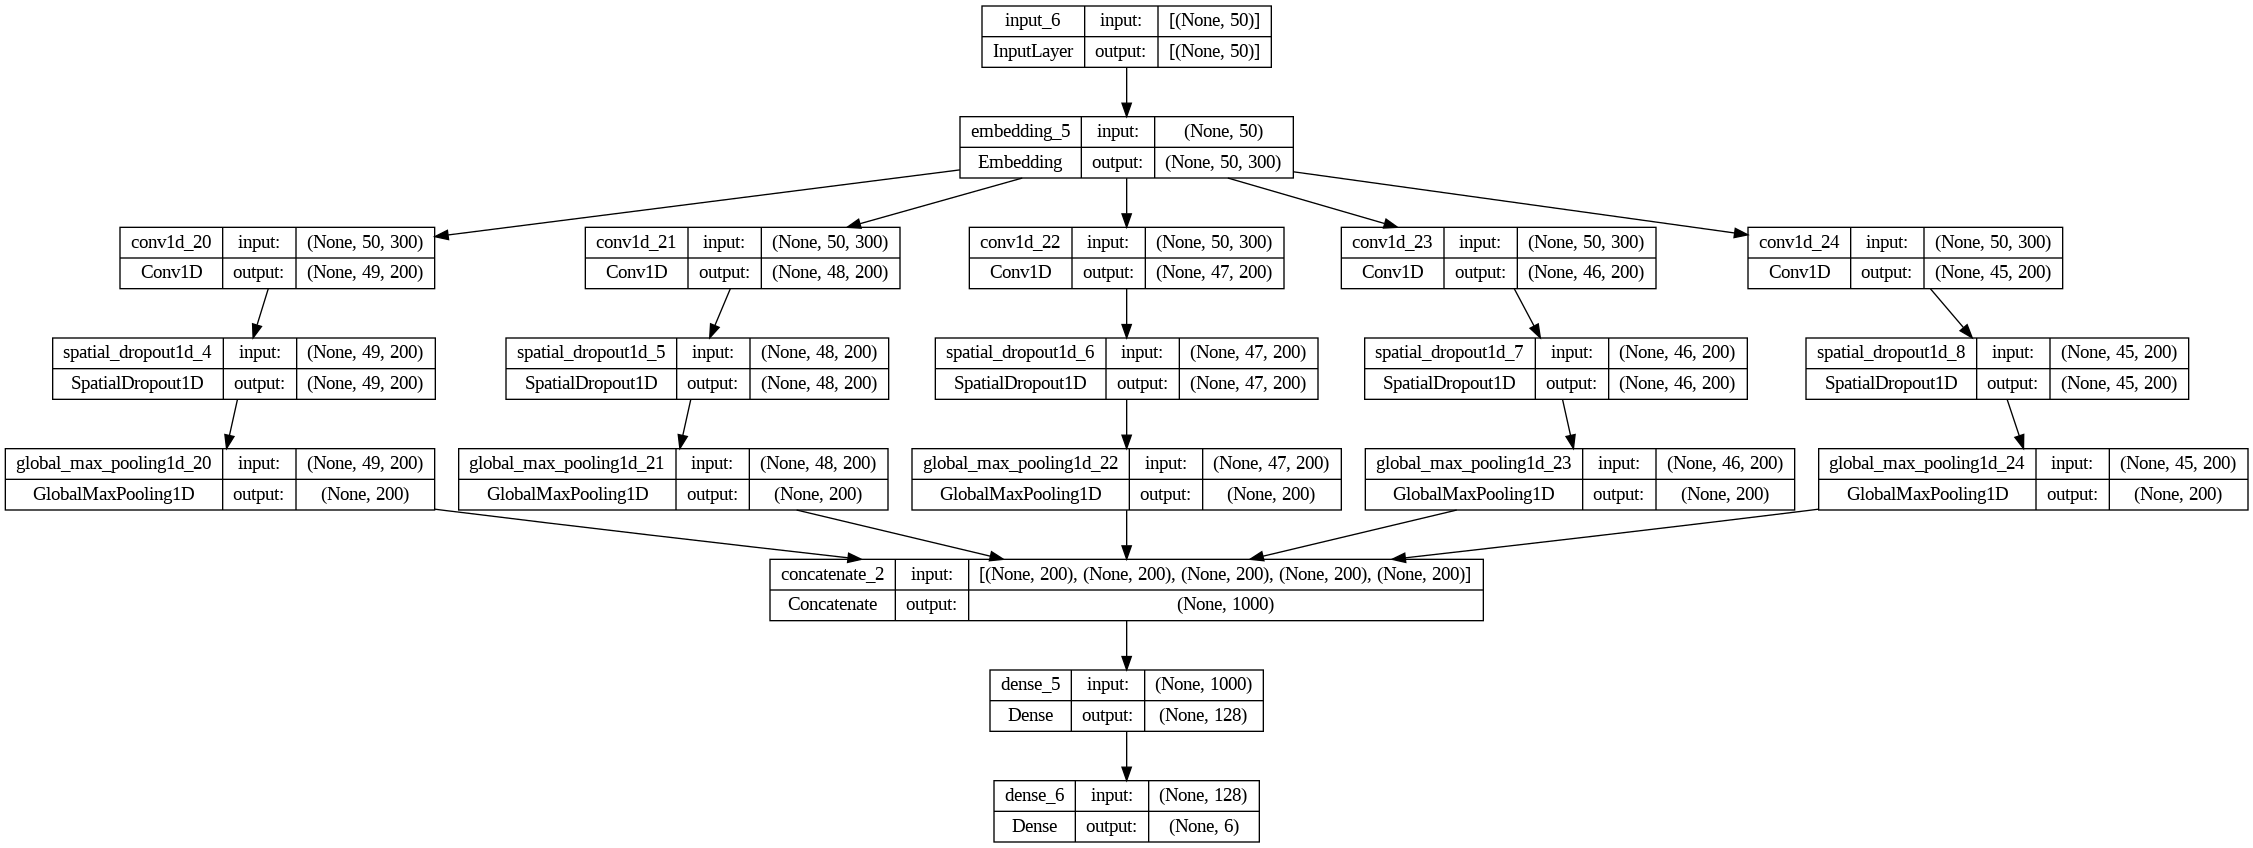

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
len(labels_names)

6

### <b>Training CNN</b>

In [ ]:
num_epochs = 10
batch_size = 128

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
hist = model.fit(x_train,
                 y_tr,
                 epochs=num_epochs,
                 validation_split=0.1,
                 shuffle=True,
                 batch_size=batch_size,
                 callbacks=[early_stopping])

Epoch 1/10
269/269 [==============================] - 244s 731ms/step - loss: 0.5867 - acc: 0.7642 - val_loss: 0.4465 - val_acc: 0.8135
Epoch 2/10
269/269 [==============================] - 198s 738ms/step - loss: 0.4045 - acc: 0.8320 - val_loss: 0.4209 - val_acc: 0.8130
Epoch 3/10
269/269 [==============================] - 199s 739ms/step - loss: 0.3325 - acc: 0.8604 - val_loss: 0.4291 - val_acc: 0.8080
Epoch 4/10
269/269 [==============================] - 196s 729ms/step - loss: 0.2707 - acc: 0.8871 - val_loss: 0.4608 - val_acc: 0.8135
Epoch 5/10
269/269 [==============================] - 195s 727ms/step - loss: 0.2293 - acc: 0.9052 - val_loss: 0.4819 - val_acc: 0.8120
Epoch 5: early stopping


In [ ]:
predictions = model.predict(x_test,
                            batch_size=1024,
                            verbose=1)

10/10 [==============================] - 23s 2s/step


In [ ]:
labels = labels_name
labels

['not_cyberbullying',
 'gender',
 'religion',
 'other_cyberbullying',
 'age',
 'ethnicity']

In [ ]:
predictions_labels = createPredictionsLabels(predictions, labels_name)
print(len(predictions_labels), predictions_labels[:10])

9532 ['age', 'gender', 'age', 'age', 'age', 'age', 'not_cyberbullying', 'age', 'other_cyberbullying', 'age']


### <b>Metrics</b>

In [ ]:
cm = confusion_matrix(y_test, predictions_labels, labels=labels_name)
print(cm)

[[1564    0    3   16   15    0]
 [   2 1554    6   13   15    2]
 [   0    9 1302  160  117    2]
 [  15   20   59  875  570   48]
 [  12   17   83  550  899    4]
 [   1    3   12   60   26 1498]]


In [ ]:
df = pd.DataFrame(cm, columns=labels_name, index=labels_name)
print(df)

                      age  ethnicity  gender  not_cyberbullying  \
age                  1564          0       3                 16   
ethnicity               2       1554       6                 13   
gender                  0          9    1302                160   
not_cyberbullying      15         20      59                875   
other_cyberbullying    12         17      83                550   
religion                1          3      12                 60   

                     other_cyberbullying  religion  
age                                   15         0  
ethnicity                             15         2  
gender                               117         2  
not_cyberbullying                    570        48  
other_cyberbullying                  899         4  
religion                              26      1498  


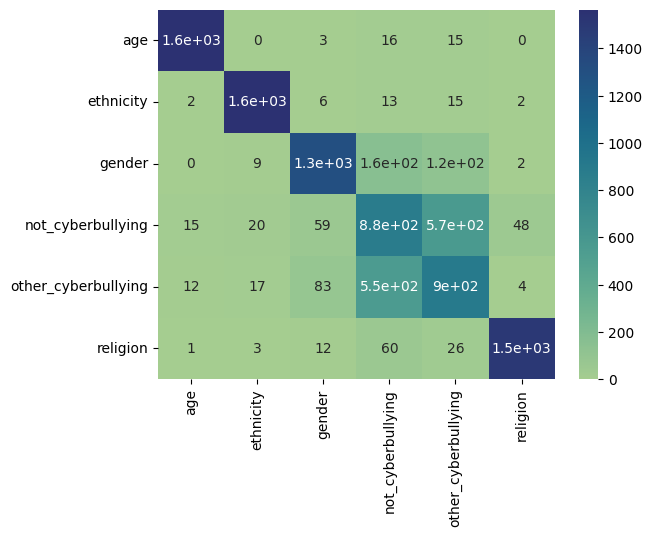

In [ ]:
heatmap = sns.heatmap(df, annot=True, cmap="crest")

In [ ]:
print(classification_report(y_true=y_test, y_pred=predictions_labels, labels=labels_name,target_names=labels_name))

                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1598
          ethnicity       0.97      0.98      0.97      1592
             gender       0.89      0.82      0.85      1590
  not_cyberbullying       0.52      0.55      0.54      1587
other_cyberbullying       0.55      0.57      0.56      1565
           religion       0.96      0.94      0.95      1600

           accuracy                           0.81      9532
          macro avg       0.81      0.81      0.81      9532
       weighted avg       0.81      0.81      0.81      9532



------------------------------------------------

-------------------------------------------------------------------------------

### <b>Ensembles Algorithms</b>



In [ ]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import Ridge

In [ ]:
# bagging = BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=10, random_state=0)

In [ ]:
# bagging.fit(x_train, y_tr)

In [ ]:
# predictions_bag = bagging.predict(x_test)

In [ ]:
# def createLabels(predictions, labels):
#   l = []
#   for i in predictions:
#     l.append(labels[i])
#   return l

In [ ]:
# predictions_labels_bag = createLabels(predictions_bag, labels_names)
# print(predictions_labels_bag[:5])

In [ ]:
# print(classification_report(y_true=y_test, y_pred=predictions_labels_bag, labels=labels_names,target_names=labels_names))

### Light Gradient Boosting

In [ ]:
# !pip install lightgbm

In [ ]:
# import lightgbm as lgb

In [ ]:
# param = {'num_leaves': 31, 'objective': 'multiclass', 'num_class': 6}
# num_round = 10
# train_data = lgb.Dataset(x_train, label=y_tr, free_raw_data=False)

In [ ]:
# lgb.Dataset.construct(train_data)

In [ ]:
# train_data.get_data()

In [ ]:
# bst = lgb.train(param, train_data, num_round)

In [ ]:
# lgbm_predictions = bst.predict(x_test)

In [ ]:
# lgbm_predictions_labels = createPredictionsLabels(lgbm_predictions, labels)
# lgbm_predictions_labels[:15]

In [ ]:
# print(classification_report(y_true=y_test, y_pred=lgbm_predictions_labels, labels=labels,target_names=labels))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
# param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
# base_estimator = RandomForestClassifier(random_state=555)
# sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_estimators', max_resources=30).fit(x_train, y_tr)

In [ ]:
# sh.best_estimator_

In [ ]:
# rfc = RandomForestClassifier(n_estimators=24, max_depth=10, min_samples_split=5, random_state=555)

In [ ]:
# rfc.fit(x_train, y_tr)

In [ ]:
# predictions_rfc = rfc.predict(x_test)
# print(predictions_rfc[:10])

In [ ]:
# predictions_rfc_labels = createLabels(predictions_rfc, labels_names)

In [ ]:
# print(classification_report(y_true=y_test, y_pred=predictions_rfc_labels, labels=labels_names,target_names=labels_names))